In [33]:
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Helper Functions
# ============================================================
def smooth(values, window_size=200):
    """Centered moving average (Pandas-based)."""
    if len(values) < window_size:
        return np.array(values)
    s = pd.Series(values)
    return s.rolling(window=window_size, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Nonparametric tolerance interval."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def compute_reavg_curves(runs, common_steps, start_step):
    """Compute re-averaged episode returns after start_step."""
    reavg = []
    for steps, ep_ret, _ in runs:
        mask = steps >= start_step
        if not np.any(mask):
            continue
        ep = ep_ret[mask]
        st = steps[mask]
        roll = np.cumsum(ep) / np.arange(1, len(ep) + 1)
        interp = np.interp(common_steps, st, roll, left=np.nan, right=np.nan)
        reavg.append(interp)
    if not reavg:
        return None
    return np.array(reavg)

def extract_ppo_params(fn):
    """Extract PPO parameters from filename for legend labels."""
    c = re.search(r"clip_param=([\d\.]+)", fn)
    kl = re.search(r"target_kl=([\d\.]+)", fn)
    pi = re.search(r"train_policy_iters=(\d+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    return f"clip={c.group(1) if c else '?'}, kl={kl.group(1) if kl else '?'}, pi={pi.group(1) if pi else '?'}, vf={vf.group(1) if vf else '?'}"

# ============================================================
# 🚀 PPO Analysis Function (with env name, subtitle, and save option)
# ============================================================
def analyze_ppo_logs(
    log_dir,
    env_name="Unknown Environment",
    start_step=900_000,
    subtitle=None,
    figsize=(18, 14),
    window_size=200,
    save_fig=False,
):
    """
    Analyze PPO training logs and plot average/re-averaged performance.

    Parameters
    ----------
    log_dir : str or Path
        Directory containing PPO JSON log files.
    env_name : str
        Name of the environment (e.g., 'HalfCheetah-v3', 'Ant-v2').
    start_step : int
        Step threshold to start re-averaging.
    subtitle : str, optional
        Text appended to figure title or printed below.
    figsize : tuple
        Figure size for the two-panel plot.
    window_size : int
        Smoothing window for moving average.
    save_fig : bool
        Whether to save the figure as a PNG in the log directory.
    """

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} PPO logs.")
    if not files:
        raise FileNotFoundError("No PPO log files found!")

    # --------------------------
    # Helper: load one training curve
    # --------------------------
    def load_training_curve(p):
        with p.open("r") as f:
            d = json.load(f)
        ev = [e for e in d.get("events", []) if e.get("event") == "train_episode"]
        steps = np.array([e.get("total_steps", 0) for e in ev])
        ep = np.array([e.get("episode_return", np.nan) for e in ev])
        av = np.array([e.get("average_return", np.nan) for e in ev])
        return steps, ep, av

    # --------------------------
    # Group runs by config (ignore seed)
    # --------------------------
    cfg_groups = defaultdict(list)
    for p in files:
        try:
            s, ep, av = load_training_curve(p)
            if len(s) == 0:
                continue
            cfg = re.sub(r"_seed=\d+", "", p.name)
            cfg_groups[cfg].append((s, ep, smooth(av, window_size)))
        except Exception as e:
            print(f"⚠️ {p.name}: {e}")

    print(f"Found {len(cfg_groups)} unique PPO configs.")

    BETA, ALPHA = 0.9, 0.05
    curves, ranking = {}, []

    # --------------------------
    # Compute mean, tolerance bands, and re-averages
    # --------------------------
    for cfg, runs in cfg_groups.items():
        if not runs:
            continue
        minlen = min(r[0][-1] for r in runs if len(r[0]) > 0)
        common = np.linspace(0, minlen, 300)

        interp_full = np.array([np.interp(common, s, a) for s, _, a in runs])
        mean_full = np.nanmean(interp_full, 0)
        low_full, up_full = tol_interval(interp_full, BETA, ALPHA)

        reavg_curves = compute_reavg_curves(runs, common, start_step)
        if reavg_curves is None:
            continue
        mean_re = np.nanmean(reavg_curves, 0)
        low_re, up_re = tol_interval(reavg_curves, BETA, ALPHA)

        curves[cfg] = dict(
            steps=common,
            mean_full=mean_full, low_full=low_full, up_full=up_full,
            mean_reavg=mean_re, low_reavg=low_re, up_reavg=up_re,
        )

        mask = common >= start_step
        mean_perf = np.nanmean(mean_re[mask])
        std_perf = np.nanstd(mean_re[mask])
        ranking.append((extract_ppo_params(cfg), mean_perf, std_perf, mean_perf / (std_perf + 1e-8)))

    # --------------------------
    # Ranking table
    # --------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Mean≥900k", "Std≥900k", "Mean/Std"])
    print(f"\n📊 PPO Re-Averaged Performance (≥{start_step:,} steps):\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Mean≥900k": "{:,.2f}".format,
        "Std≥900k": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format
    }))

    # --------------------------
    # Plot
    # --------------------------
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    title_text = f"PPO Average Return – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight='bold', y=0.98)

    def panel(a, key, low, up, title):
        for i, (cfg, data) in enumerate(curves.items()):
            c = f"C{i % 10}"
            a.plot(data["steps"], data[key], color=c, lw=1.5, alpha=0.8, label=extract_ppo_params(cfg))
            a.fill_between(data["steps"], data[low], data[up], color=c, alpha=0.1)
        a.set_title(title, fontsize=13)
        a.set_xlabel("Cumulative Steps")
        a.set_ylabel("Average Return")
        a.grid(alpha=0.3, linestyle="--")
        a.ticklabel_format(style="plain", axis="x")

    panel(ax[0], "mean_full", "low_full", "up_full", "Average Return (Starting from t=0 Steps)")
    panel(ax[1], "mean_reavg", "low_reavg", "up_reavg", f"Average Return (Starting from t=900k Steps)")

    h, l = ax[0].get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])

    if save_fig:
        out_path = folder / f"PPO_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()

    return df, curves


In [ ]:
# ============================================================
# 🔧 Helper Functions
# ============================================================
def smooth(v, w=200):
    """Centered moving average."""
    if len(v) < w:
        return np.array(v)
    s = pd.Series(v)
    return s.rolling(window=w, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Nonparametric tolerance interval."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def extract_trpo_params(fn):
    """Extract TRPO parameters from filename for legend labels."""
    d = re.search(r"delta=([\d\.]+)", fn)
    c = re.search(r"backtrack_coeff=([\d\.]+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    a = re.search(r"backtrack_alpha=([\d\.]+)", fn)
    return f"δ={d.group(1) if d else '?'}, coeff={c.group(1) if c else '?'}, vf={vf.group(1) if vf else '?'}, α={a.group(1) if a else '?'}"

# ============================================================
# 🚀 TRPO Analysis Function (with env name, subtitle, and save option)
# ============================================================
def analyze_trpo_logs(
    log_dir,
    env_name="Unknown Environment",
    start_step=900_000,
    subtitle=None,
    figsize=(18, 14),
    window_size=200,
    save_fig=False,
):
    """
    Analyze TRPO training logs and plot average/re-averaged performance.

    Parameters
    ----------
    log_dir : str or Path
        Directory containing TRPO JSON log files.
    env_name : str
        Name of the environment (e.g., 'HalfCheetah-v3', 'Ant-v2').
    start_step : int
        Step threshold to start re-averaging.
    subtitle : str, optional
        Text appended to figure title or printed below.
    figsize : tuple
        Figure size for the two-panel plot.
    window_size : int
        Smoothing window for moving average.
    save_fig : bool
        Whether to save the figure as a PNG in the log directory.
    """

    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} TRPO logs.")
    if not files:
        raise FileNotFoundError("No TRPO log files found!")

    # --------------------------
    # Load a single training curve
    # --------------------------
    def load_training_curve(p):
        with p.open("r") as f:
            d = json.load(f)
        ev = [e for e in d.get("events", []) if e.get("event") == "train_episode"]
        steps = np.array([e.get("total_steps", 0) for e in ev])
        ep = np.array([e.get("episode_return", np.nan) for e in ev])
        av = np.array([e.get("average_return", np.nan) for e in ev])
        return steps, ep, av

    # --------------------------
    # Group runs by config (ignore seed)
    # --------------------------
    cfg_groups = defaultdict(list)
    for p in files:
        try:
            s, ep, av = load_training_curve(p)
            if len(s) == 0:
                continue
            cfg = re.sub(r"_seed=\d+", "", p.name)
            cfg_groups[cfg].append((s, ep, smooth(av, window_size)))
        except Exception as e:
            print(f"⚠️ {p.name}: {e}")

    print(f"Found {len(cfg_groups)} unique TRPO configs.")

    BETA, ALPHA = 0.9, 0.05
    curves, ranking = {}, []

    # --------------------------
    # Compute mean, tolerance bands, and re-averaged curves
    # --------------------------
    for cfg, runs in cfg_groups.items():
        if not runs:
            continue
        minlen = min(r[0][-1] for r in runs if len(r[0]) > 0)
        common = np.linspace(0, minlen, 300)

        interp_full = np.array([np.interp(common, s, a) for s, _, a in runs])
        mean_full = np.nanmean(interp_full, 0)
        low_full, up_full = tol_interval(interp_full, BETA, ALPHA)

        reavg_curves = []
        for s, ep, a in runs:
            m = s >= start_step
            if np.sum(m) == 0:
                continue
            epc, sc = ep[m], s[m]
            roll = np.cumsum(epc) / np.arange(1, len(epc) + 1)
            reavg_curves.append(np.interp(common, sc, roll, left=np.nan, right=np.nan))
        if not reavg_curves:
            continue

        reavg_curves = np.array(reavg_curves)
        mean_re = np.nanmean(reavg_curves, 0)
        low_re, up_re = tol_interval(reavg_curves, BETA, ALPHA)

        curves[cfg] = dict(
            steps=common,
            mean_full=mean_full, low_full=low_full, up_full=up_full,
            mean_reavg=mean_re, low_reavg=low_re, up_reavg=up_re,
        )

        mask = common >= start_step
        mean_perf = np.nanmean(mean_re[mask])
        std_perf = np.nanstd(mean_re[mask])
        ranking.append((extract_trpo_params(cfg), mean_perf, std_perf, mean_perf / (std_perf + 1e-8)))

    # --------------------------
    # Ranking table
    # --------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Mean≥900k", "Std≥900k", "Mean/Std"])
    print(f"\n📊 TRPO Re-Averaged Performance (≥{start_step:,} steps):\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Mean≥900k": "{:,.2f}".format,
        "Std≥900k": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format,
    }))

    # --------------------------
    # Plot
    # --------------------------
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    title_text = f"TRPO Average Return – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight="bold", y=0.98)

    def panel(a, key, low, up, title):
        for i, (cfg, data) in enumerate(curves.items()):
            col = f"C{i % 10}"
            a.plot(data["steps"], data[key], color=col, lw=1.5, alpha=0.8, label=extract_trpo_params(cfg))
            a.fill_between(data["steps"], data[low], data[up], color=col, alpha=0.1)
        a.set_title(title, fontsize=13)
        a.set_xlabel("Cumulative Steps")
        a.set_ylabel("Average Return")
        a.grid(alpha=0.3, linestyle="--")
        a.ticklabel_format(style="plain", axis="x")

    panel(ax[0], "mean_full", "low_full", "up_full", "Average Return (Starting from t=0 Steps)")
    panel(ax[1], "mean_reavg", "low_reavg", "up_reavg", f"Average Return (Starting from t=900k Steps)")

    h, l = ax[0].get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])

    if save_fig:
        out_path = folder / f"TRPO_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()

    return df, curves


Found 24 TRPO logs.
Found 12 unique TRPO configs.

📊 TRPO Re-Averaged Performance (≥900,000 steps):

Config                           Mean≥900k Std≥900k Mean/Std
 δ=0.01, coeff=0.8, vf=10, α=0.5 1,795.43  101.73   17.65   
   δ=0.02, coeff=1, vf=10, α=0.5 1,759.45  149.58   11.76   
   δ=0.01, coeff=1, vf=10, α=0.5 1,742.53   45.58   38.23   
   δ=0.02, coeff=1, vf=80, α=0.5 1,489.24  163.90    9.09   
  δ=0.01, coeff=1, vf=120, α=0.5 1,425.76  152.26    9.36   
 δ=0.02, coeff=0.8, vf=80, α=0.5 1,330.52  112.53   11.82   
 δ=0.01, coeff=0.8, vf=80, α=0.5 1,328.57   33.80   39.31   
 δ=0.02, coeff=0.8, vf=10, α=0.5   942.51   39.84   23.66   
  δ=0.02, coeff=1, vf=120, α=0.5   872.06   69.95   12.47   
δ=0.01, coeff=0.8, vf=120, α=0.5   831.23   23.04   36.08   
δ=0.02, coeff=0.8, vf=120, α=0.5   761.66  123.89    6.15   
   δ=0.01, coeff=1, vf=80, α=0.5   735.61   51.06   14.41   


C:\Users\Phong\AppData\Local\Temp\ipykernel_46820\479196414.py:134: RuntimeWarning: Mean of empty slice
  mean_re = np.nanmean(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_chet\TRPO_HalfCheetah-v5.png


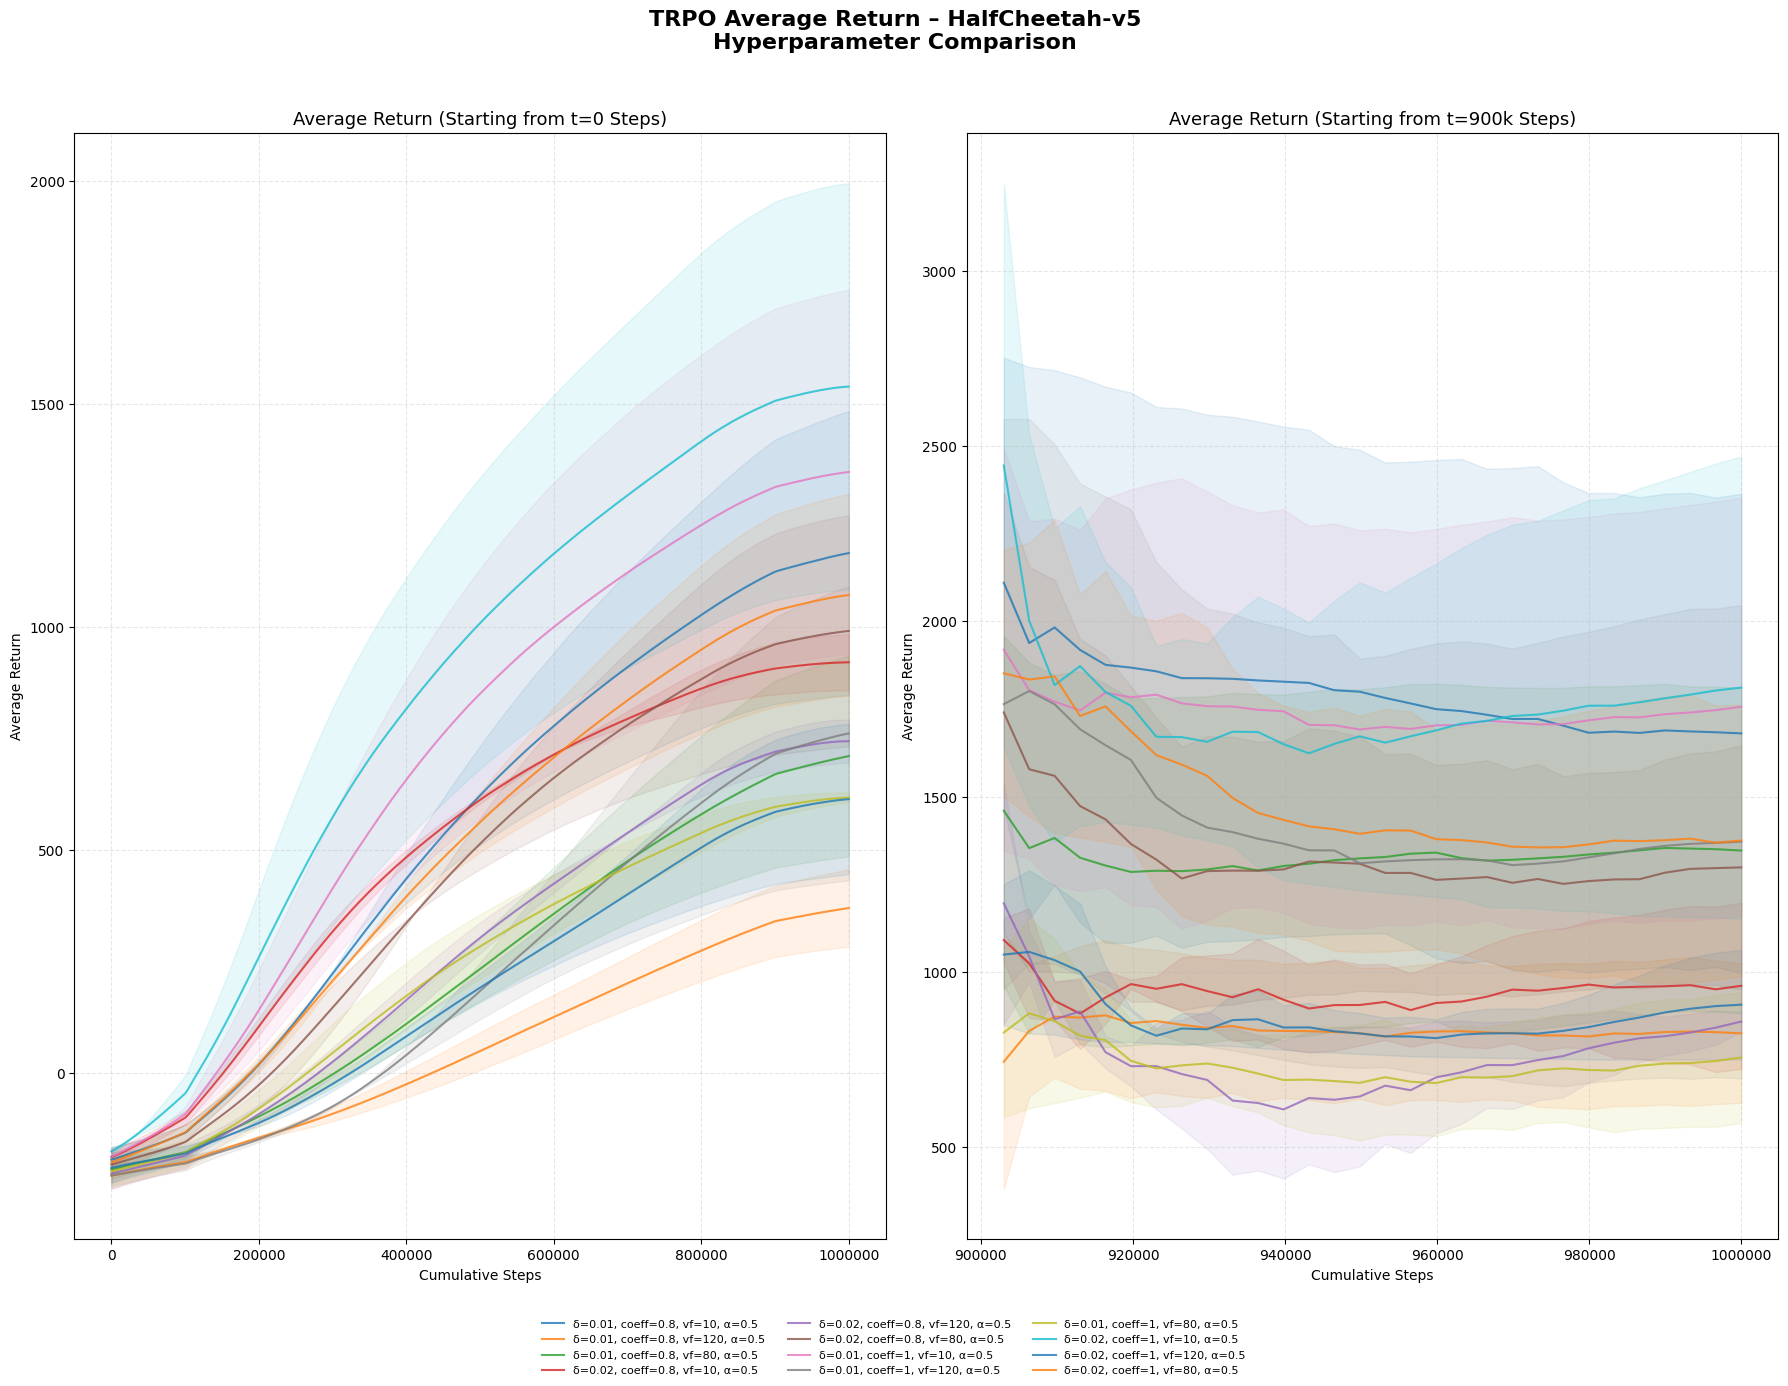

Found 32 PPO logs.
Found 16 unique PPO configs.

📊 PPO Re-Averaged Performance (≥900,000 steps):

Config                          Mean≥900k Std≥900k Mean/Std
clip=0.3, kl=0.02, pi=10, vf=10 2,180.21  250.31    8.71   
clip=0.3, kl=0.02, pi=20, vf=20 2,153.21   84.39   25.52   
clip=0.3, kl=0.02, pi=20, vf=10 2,079.89  133.43   15.59   
clip=0.3, kl=0.01, pi=20, vf=10 2,065.69   78.96   26.16   
clip=0.2, kl=0.02, pi=20, vf=10 2,019.69  132.13   15.29   
clip=0.2, kl=0.02, pi=10, vf=20 2,017.68   82.28   24.52   
clip=0.2, kl=0.01, pi=10, vf=20 1,992.24   73.16   27.23   
clip=0.3, kl=0.02, pi=10, vf=20 1,854.26   61.27   30.26   
clip=0.2, kl=0.01, pi=20, vf=20 1,746.55  133.74   13.06   
clip=0.2, kl=0.01, pi=20, vf=10 1,630.50   29.83   54.67   
clip=0.3, kl=0.01, pi=10, vf=20 1,613.94   97.79   16.50   
clip=0.3, kl=0.01, pi=10, vf=10 1,596.17  147.41   10.83   
clip=0.3, kl=0.01, pi=20, vf=20 1,430.38   60.71   23.56   
clip=0.2, kl=0.02, pi=20, vf=20 1,284.97  136.11    9.44   
cl

C:\Users\Phong\AppData\Local\Temp\ipykernel_46820\965179785.py:141: RuntimeWarning: Mean of empty slice
  mean_re = np.nanmean(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\ppo_chet\PPO_HalfCheetah-v5.png


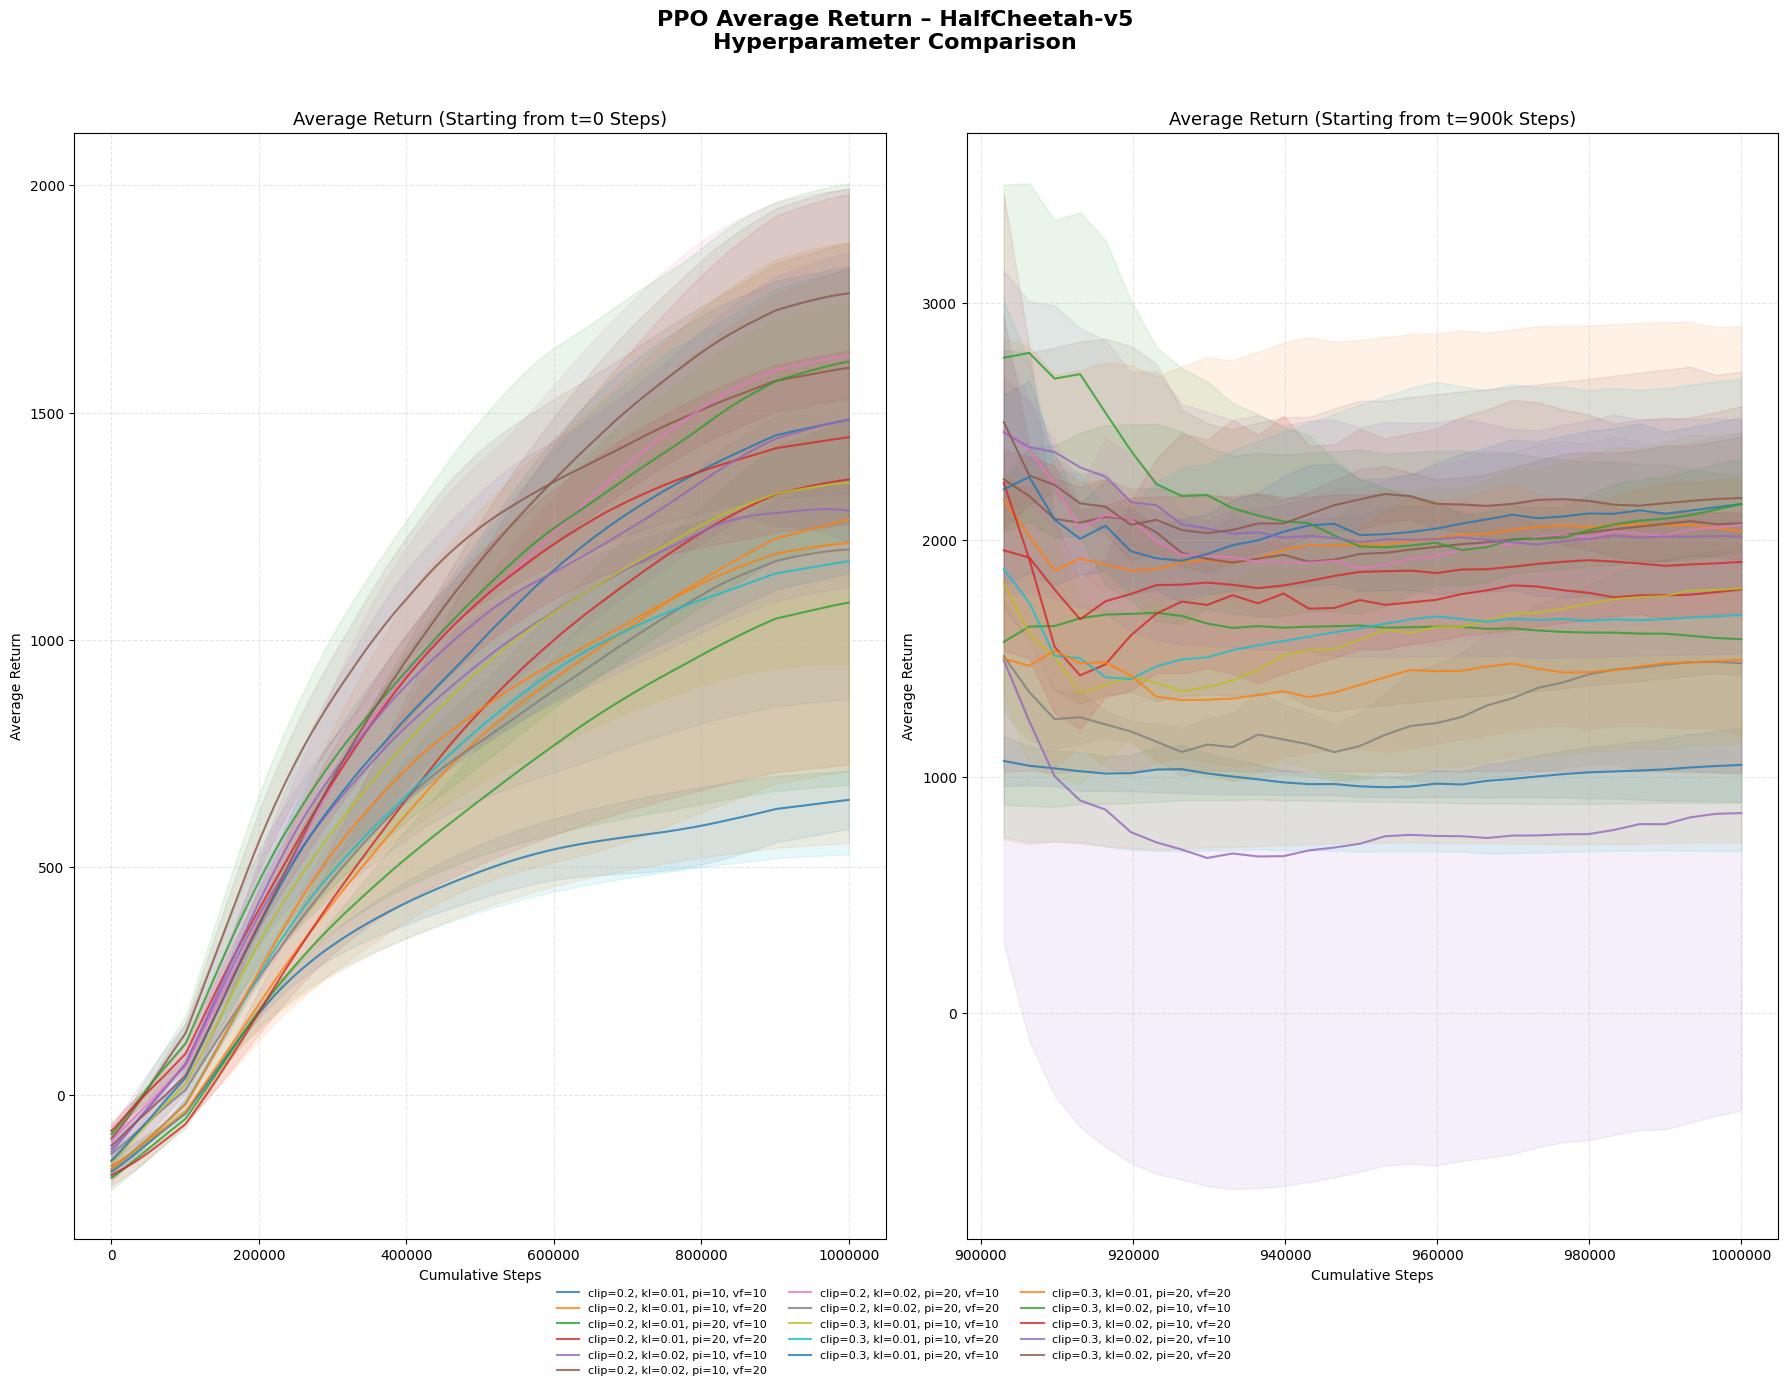

Found 24 TRPO logs.
Found 12 unique TRPO configs.

📊 TRPO Re-Averaged Performance (≥900,000 steps):

Config                           Mean≥900k Std≥900k Mean/Std
 δ=0.02, coeff=0.8, vf=10, α=0.5 387.11    21.90    17.68   
   δ=0.01, coeff=1, vf=10, α=0.5 375.68    17.23    21.80   
 δ=0.01, coeff=0.8, vf=10, α=0.5 349.80    12.68    27.59   
   δ=0.02, coeff=1, vf=10, α=0.5 322.64    20.69    15.60   
 δ=0.01, coeff=0.8, vf=80, α=0.5 150.49     7.91    19.02   
 δ=0.02, coeff=0.8, vf=80, α=0.5 114.55     4.31    26.61   
   δ=0.01, coeff=1, vf=80, α=0.5 114.48     5.43    21.10   
   δ=0.02, coeff=1, vf=80, α=0.5 112.65     4.12    27.37   
  δ=0.01, coeff=1, vf=120, α=0.5 111.40     6.92    16.10   
δ=0.01, coeff=0.8, vf=120, α=0.5 105.75     4.67    22.64   
  δ=0.02, coeff=1, vf=120, α=0.5  81.43     4.16    19.56   
δ=0.02, coeff=0.8, vf=120, α=0.5  79.35     5.22    15.19   


C:\Users\Phong\AppData\Local\Temp\ipykernel_46820\479196414.py:134: RuntimeWarning: Mean of empty slice
  mean_re = np.nanmean(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_ant\TRPO_Ant-v5.png


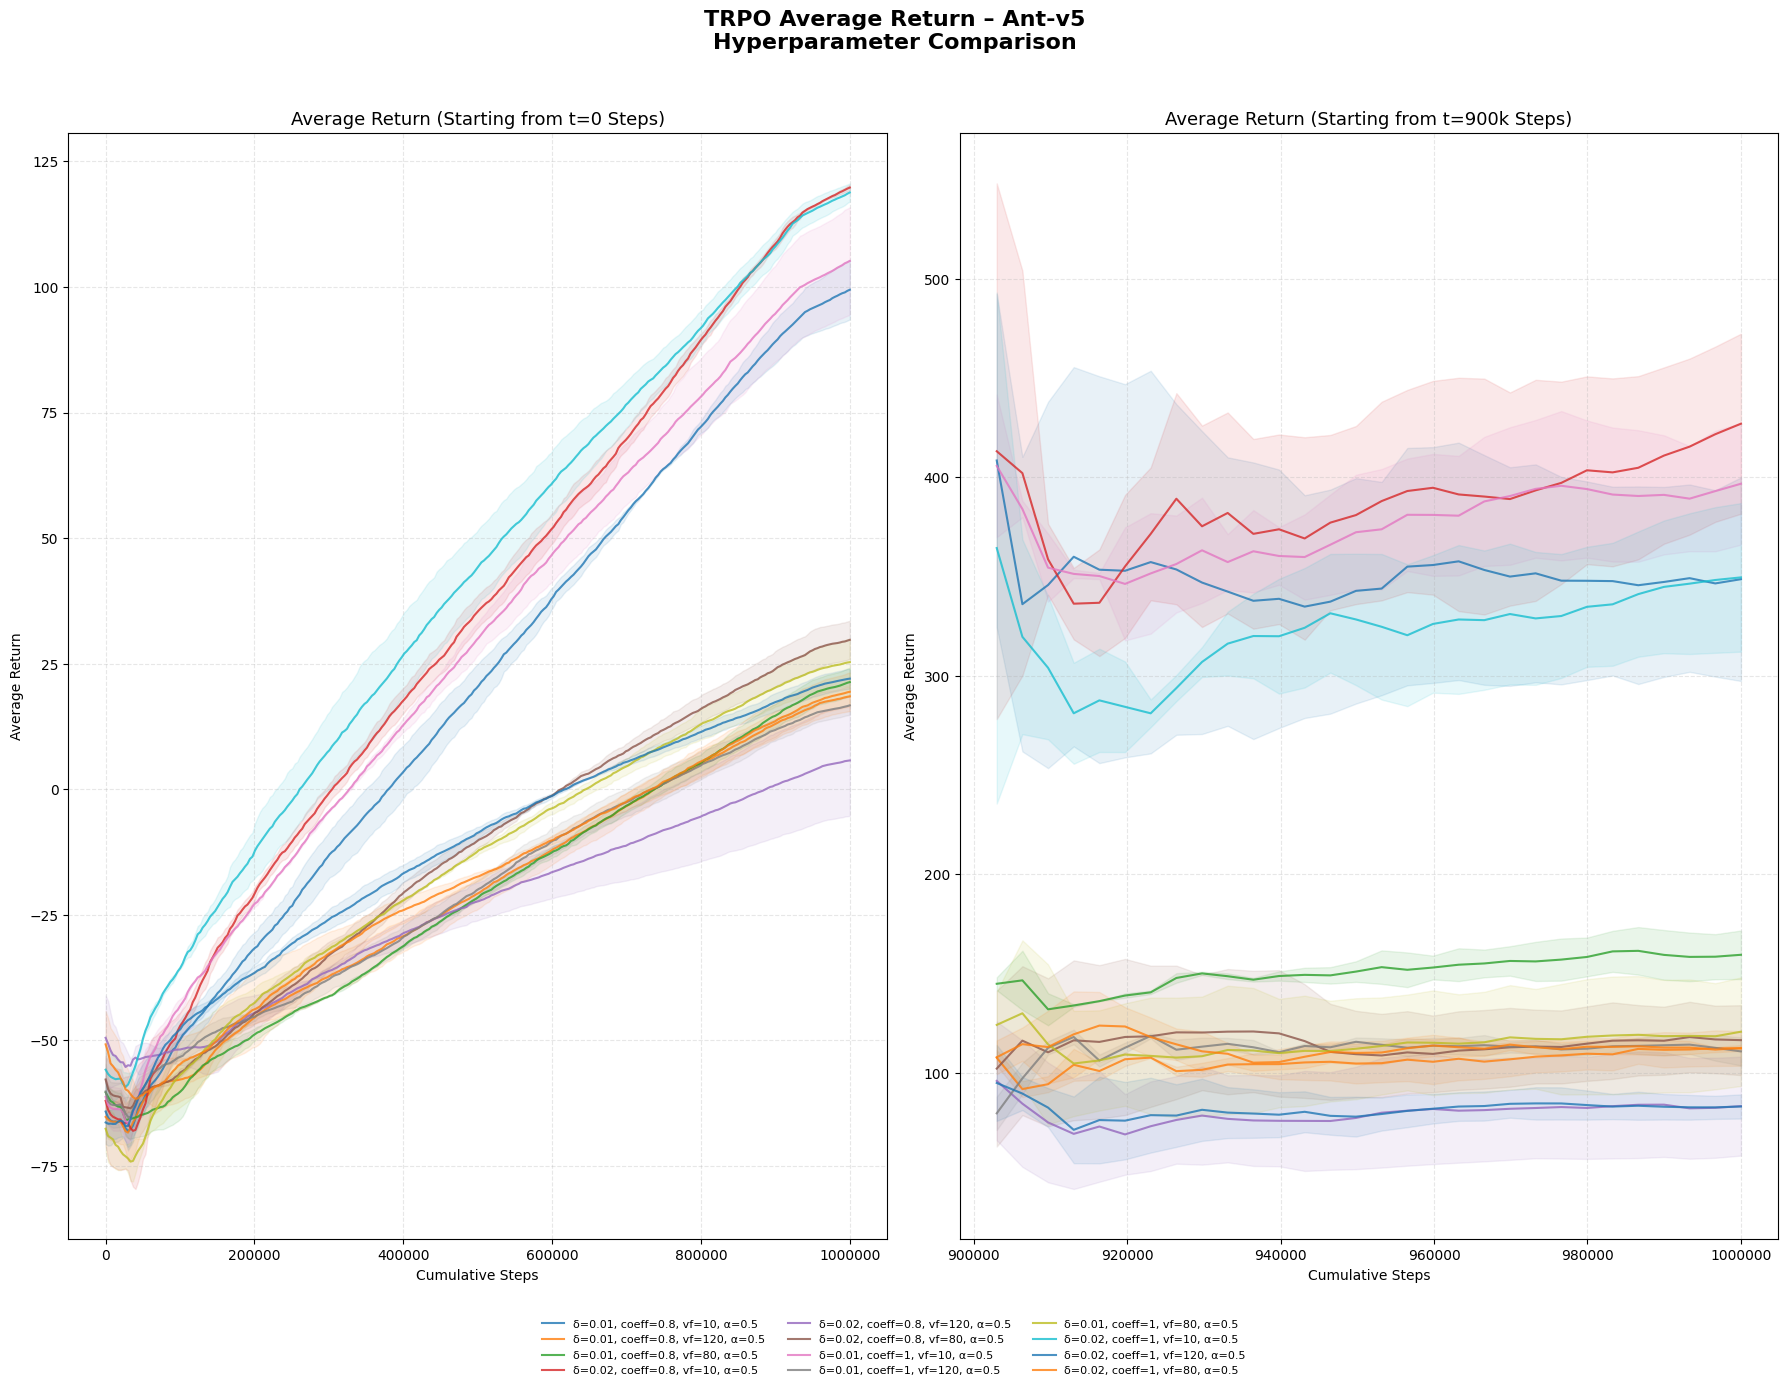

Found 32 PPO logs.
Found 16 unique PPO configs.

📊 PPO Re-Averaged Performance (≥900,000 steps):

Config                          Mean≥900k Std≥900k Mean/Std
clip=0.2, kl=0.02, pi=10, vf=10 852.23    28.34    30.08   
clip=0.2, kl=0.02, pi=20, vf=10 836.49    44.10    18.97   
clip=0.2, kl=0.02, pi=10, vf=20 745.97    27.50    27.13   
clip=0.3, kl=0.02, pi=10, vf=20 729.13    30.69    23.76   
clip=0.3, kl=0.01, pi=20, vf=10 691.73    15.54    44.52   
clip=0.2, kl=0.01, pi=10, vf=20 690.67    23.83    28.98   
clip=0.3, kl=0.02, pi=10, vf=10 689.21    64.45    10.69   
clip=0.3, kl=0.02, pi=20, vf=20 680.69    29.34    23.20   
clip=0.2, kl=0.02, pi=20, vf=20 679.99    48.18    14.11   
clip=0.2, kl=0.01, pi=10, vf=10 657.00    37.20    17.66   
clip=0.3, kl=0.01, pi=10, vf=10 651.21    22.06    29.52   
clip=0.3, kl=0.01, pi=10, vf=20 615.35    23.27    26.45   
clip=0.2, kl=0.01, pi=20, vf=10 576.77    26.70    21.60   
clip=0.3, kl=0.02, pi=20, vf=10 566.95    33.41    16.97   
cl

C:\Users\Phong\AppData\Local\Temp\ipykernel_46820\965179785.py:141: RuntimeWarning: Mean of empty slice
  mean_re = np.nanmean(reavg_curves, 0)


💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\Analysis\PPO_Ant-v5.png


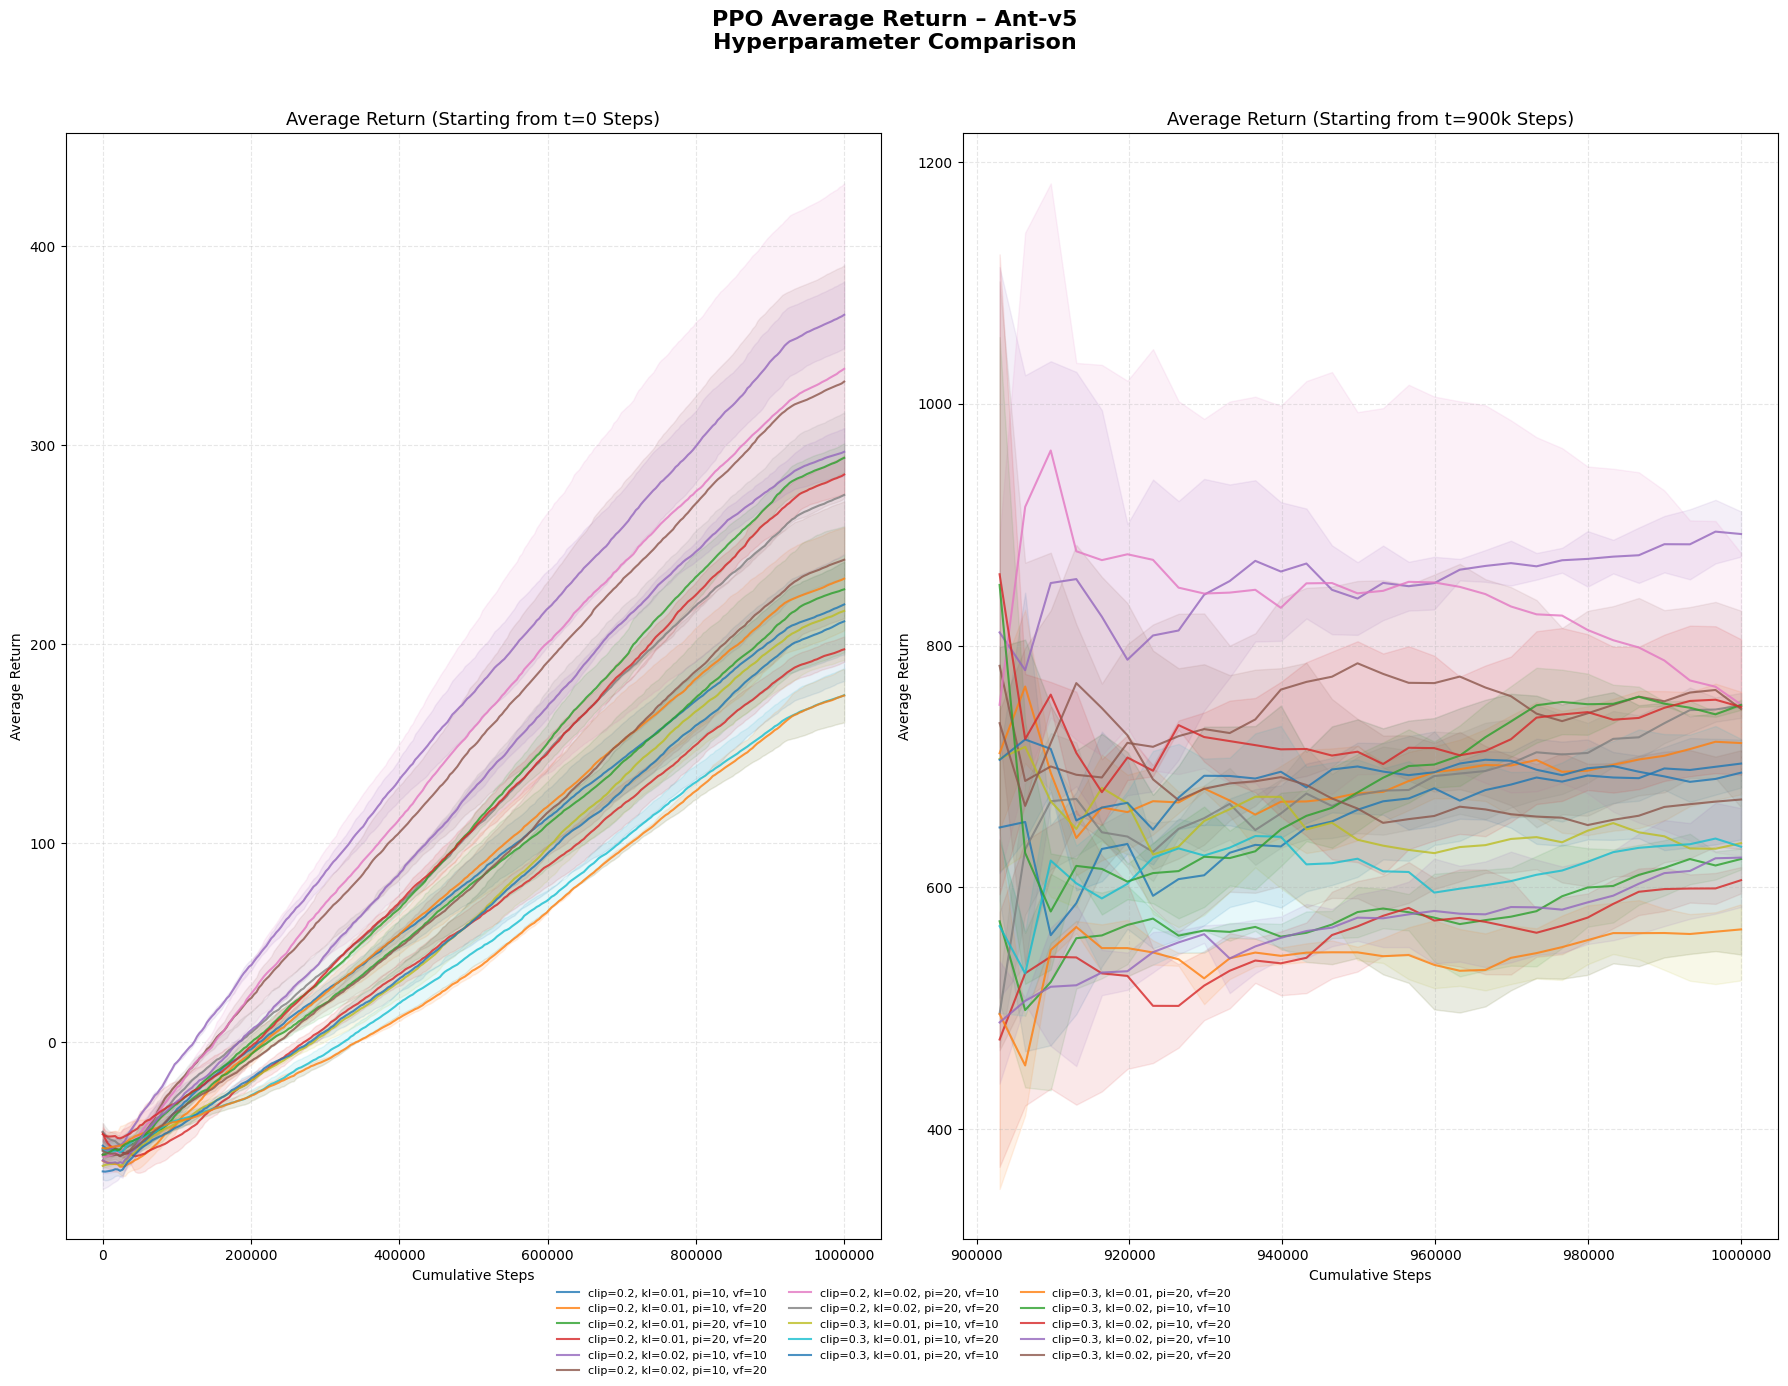

In [ ]:
df_trpo, curves_trpo = analyze_trpo_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Hyperparameter Comparison",
    save_fig=True,
)
# HalfCheetah example
df_ppo, curves_ppo = analyze_ppo_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Hyperparameter Comparison",
    save_fig=True,
)

df_trpo, curves_trpo = analyze_trpo_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant",
    env_name="Ant-v5",
    subtitle="Hyperparameter Comparison",
    save_fig=True,
)
# HalfCheetah example
df_ppo, curves_ppo = analyze_ppo_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/analysis",
    env_name="Ant-v5",
    subtitle="Hyperparameter Comparison",
    save_fig=True,
)
